In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

from missingpy import KNNImputer
from missing import missingData
import error_function
from encoding import binary_encoding, target_encoding
from lasso import rmse_cv,Lasso_importance
from normalization import normalization


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn

from pysurvival.models.survival_forest import RandomSurvivalForestModel #pip install pysurvival
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score

This is just an example notebook to run a simple model.
We use missing imputation. We select only two features as an example. Then we treat cathegorical variables with one-hot encoding (also for simplicity) and finally we fit a COX model. We then obtain the probabilities and plot the results. Finally we compute the error using brier score loss weighted.

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train = missingData(train)

test = missingData(test)

In [3]:
#Encoding (binary + target)
train,test = binary_encoding(train, test)
train,test = target_encoding(train, test)

In [4]:
#Get years from T0_date 
train.T0_date = pd.to_datetime(train.T0_date).dt.year
train.T0_date = train.T0_date.astype(float)
test.T0_date = pd.to_datetime(test.T0_date).dt.year
test.T0_date = test.T0_date.astype(float)

#Separate target and X
y_data = train[[ "specific_death", "months_survival"]]

X_data = train.drop(["specific_death", "months_survival"], axis=1)


In [5]:
#Train/test split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


In [6]:
#Normalization
X_train,X_test = normalization(X_train, X_test)
X_train.drop(['ID'],axis=1, inplace=True)

In [7]:
X_test.head()

,ID,patient_gender,patient_eye_color,patient_hair_color,patient_phototype,primary_tumour_location_coded,T0_date,cutaneous_biopsy_breslow,cutaneous_biopsy_ulceration,cutaneous_biopsy_satellitosis,...,LAB2679,LAB4176,neutrofils_per_limfocits,limfocits_per_monocits,LABGF_filtrat_glomerular,missLymp,missLAB,missBIO,missBIO2,missNEU
1159,ID3610,0,0.000000,0.000000,0.00,0.454397,0.002481,0.065185,103.138839,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,1.0,1.0,1.0
2017,ID7802,0,0.000000,0.000000,0.00,0.189758,0.007940,0.002222,103.138839,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,1.0
978,ID3104,1,0.240237,0.140584,0.75,0.396445,0.002978,0.064444,103.138839,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,1.0
759,ID2540,1,0.000000,0.000000,0.00,0.191452,0.000496,0.005926,103.138839,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,1.0
874,ID2827,1,0.000000,0.000000,0.00,0.191452,0.002978,0.002222,103.138839,0,...,0.005531,0.051429,0.103756,0.170977,0.72893,0.0,0.0,0.0,0.0,0.0


Lasso picked 52 variables and eliminated the other 2 variables
patient_gender                    -2.037778
patient_eye_color                109.120940
patient_hair_color                 5.508829
patient_phototype                  3.744109
primary_tumour_location_coded     52.801253
dtype: float64


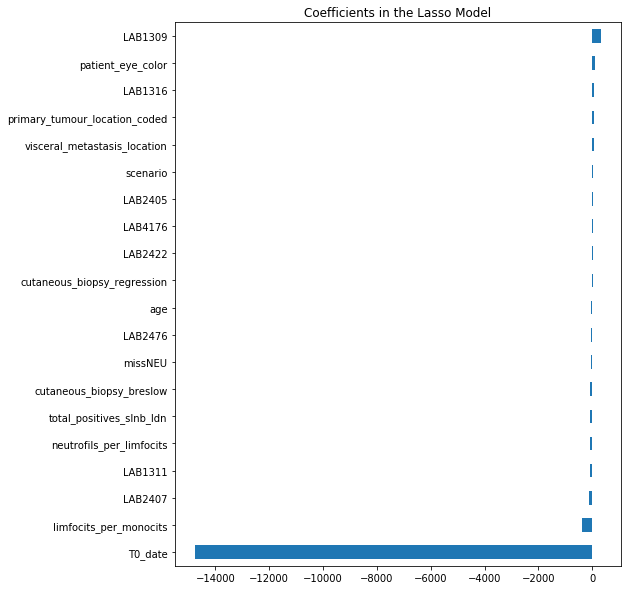

In [8]:
# Feature selection

coefs = Lasso_importance(X_train, y_train.months_survival)

In [9]:
coefs.sort_values(ascending=False, inplace=True)


In [10]:
selected_columns = coefs[np.abs(coefs)>3].index

In [11]:
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

In [12]:
def fit_model(x_train, y_train,x_test,y_test):
    # Building the model
    rsf = RandomSurvivalForestModel(num_trees=200)
    # Fit model
    rsf.fit(x_train, y_train.months_survival.values, y_train.specific_death.values,
            max_features="sqrt", max_depth=50, min_node_size=10, seed=42)

    #### - Cross Validation / Model Performances
 #   c_index = concordance_index(rsf,  x_test.values, y_test.months_survival.values,y_test.specific_death.values) #0.81
 #   print('C-index: {:.2f}'.format(c_index))


 #   ibs = integrated_brier_score(rsf, x_test.values, y_test.months_survival.values,y_test.specific_death.values
 #               , t_max=30,figure_size=(20, 6.5) )
 #   print('IBS: {:.2f}'.format(ibs))

    return rsf

In [13]:
estimator = fit_model(X_train_selected, y_train, X_test_selected,y_test)

In [14]:
def get_probabilities(x_test, estimator):
    
    # Create an empty pandas dataframes with these times as the columns
    pred = estimator.predict_survival(x_test.values[0, :]).flatten()
    times = np.arange(pred.shape[0])
    pred_df = pd.DataFrame(columns = times )
    
    # Convert each row to a pandas series row (transpose) with the index as these x times and append it to the df
    for i in range(0,len(x_test)):
        pred = estimator.predict_survival(x_test.values[i, :])
        pred_df = pred_df.append(pd.DataFrame(pred)) 

    pred_df = pred_df.set_index(np.arange(pred_df.shape[0]))

    return pred_df,times

In [15]:
#  store the probability curves
predictions,times = get_probabilities(X_test_selected, estimator)

#predictions.head()  

In [16]:
# Plot survival curves for certain observations (here we take first 3 observations)
#for curve in predictions.values[0:3]:
#    plt.step(times, curve, where="post")


In [17]:
#Calculate error

weights = error_function.calc_weights(y_test) 
error = error_function.brier_score_loss_weighted(pred = predictions,actual = y_test, weights = weights)


print("Overall error: ", error)


Overall error:  0.06343230961500457


In [18]:
importance = pd.DataFrame(estimator.variable_importance.values(), index =  estimator.variable_importance.keys(),
                          columns =['importance'])
importance.sort_values(by="importance", ascending=False, inplace=True)

selected_columns = importance[abs(importance.importance)>1].index
importance

,importance
cutaneous_biopsy_breslow,25.438432
total_positives_slnb_ldn,11.562558
total_count_slnb_ldn,11.519937
scenario,10.885672
cutaneous_biopsy_histological_subtype,10.082155
patient_hair_color,7.026292
visceral_metastasis_location,6.540475
patient_phototype,6.496572
patient_eye_color,6.047970
age,5.677148


In [19]:
selected_columns

Index(['cutaneous_biopsy_breslow', 'total_positives_slnb_ldn',
       'total_count_slnb_ldn', 'scenario',
       'cutaneous_biopsy_histological_subtype', 'patient_hair_color',
       'visceral_metastasis_location', 'patient_phototype',
       'patient_eye_color', 'age', 'cutaneous_biopsy_mitotic_index',
       'cutaneous_biopsy_lymphatic_invasion', 'MC1R', 'LAB2419', 'LAB1309',
       'LAB2467', 'LAB2469', 'neutrofils_per_limfocits', 'LAB1307', 'LAB2544',
       'LAB2406', 'LAB2498', 'primary_tumour_location_coded', 'LAB1314',
       'LAB2422', 'T0_date', 'LAB2405', 'LAB1301', 'LAB1311',
       'limfocits_per_monocits', 'LAB1316', 'LABGF_filtrat_glomerular',
       'LAB2404', 'LAB4176', 'LAB2679', 'LAB2476',
       'cutaneous_biopsy_regression', 'missBIO', 'missNEU',
       'cutaneous_biopsy_associated_nevus', 'count_inv_prec_tumour',
       'cutaneous_biopsy_predominant_cell_type'],
      dtype='object')

In [20]:
from pysurvival.utils import save_model
save_model(estimator, '/home/laia/Escriptori/Master/Agile Data Science/Project/RF_model.zip')


Saving the model to disk as /home/laia/Escriptori/Master/Agile Data Science/Project/RF_model.zip


In [21]:
from pysurvival.utils import load_model
estimator_loaded = load_model('/home/laia/Escriptori/Master/Agile Data Science/Project/RF_model.zip')

Loading the model from /home/laia/Escriptori/Master/Agile Data Science/Project/RF_model.zip
